# Week 1 lab: Coin flips

## Goals

* Build a simple model based on synthetic count data: number of elevator failures per year in a building
* Run inference in the model, and make decisions using posterior predictions

## The plan

* load synthetic data: number of elevator failures per year for your building and three nearby buildings
* model data as a Poisson-distributed variable, using a Gamma distribution as a prior over the Poisson intensity
* use posterior predictions about your model to ___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pystan

%matplotlib inline

### Load the data

In [2]:
failures = pd.read_csv("elevator_failures.csv")
failures

,you,friend1,friend2,friend3
0,2,6,4,2
1,2,1,2,3
2,3,4,2,0
3,4,4,4,2
4,4,5,3,3


## Build the model

Let's assume that the elevator failures happen at a constant probability per time of happening and are uncorrelated with each other- so they'll be described reasonbly well by a homogeneous Poisson process.

The Poisson likelihood has one parameter ($\lambda$) that is equal to both the mean and the standard deviation of the distribution. $\lambda$ has to be nonnegative but doesn't have an upper bound, so we'll use a Gamma distribution.

Prior:

$\lambda \sim gamma(a,b)$

Likelihood:

$y \sim Poisson(\lambda)$

**Note:** numpy uses (`shape`, `scale`) to parameterize Gamma distribution; stan uses (`alpha`, `beta`) where `alpha=shape` and `beta=1/scale`. Example samples from a Gamma distribution:

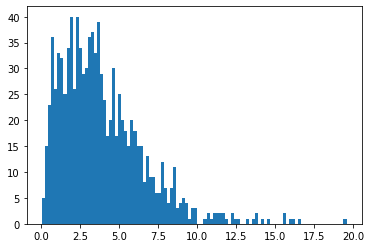

In [3]:
a = 2
b = 2
prior_samples = np.random.gamma(a,b, size=1000)
_ = plt.hist(prior_samples, bins=100);

Now build the stan model:

In [4]:
model_code = """
data {
    int<lower=0> N;
    int<lower=0> y[N];
}
parameters {
    real<lower=0> lam;
}
model {
    lam ~ gamma(2,0.5); // SPECIFY YOUR PRIOR HYPERPARAMETERS HERE
    for (n in 1:N)
        y[n] ~ poisson(lam);
}
"""

In [5]:
%%time
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_49080d2d7f9bac17465d8825fc321c13 NOW.


CPU times: user 1.52 s, sys: 99.7 ms, total: 1.62 s
Wall time: 53.5 s


## Draw samples from the posterior

Run inference on the data from your building.

In [6]:
data = {"y":failures["you"], "N":len(failures)}

In [7]:
fit = model.sampling(data=data, iter=10000, chains=4)

In [8]:
fit

Inference for Stan model: anon_model_49080d2d7f9bac17465d8825fc321c13.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lam    3.09  8.9e-3   0.75   1.79   2.56   3.02   3.56   4.71   7036    1.0
lp__   1.68  8.8e-3   0.72  -0.38   1.51   1.95   2.13   2.18   6664    1.0

Samples were drawn using NUTS at Fri Sep 13 23:27:50 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [9]:
posterior_samples = fit.extract()["lam"]
posterior_samples.shape

(20000,)

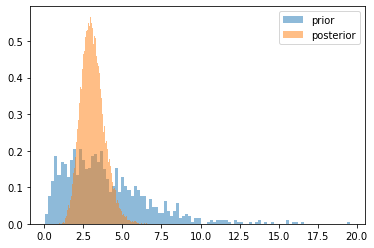

In [10]:
_ = plt.hist(prior_samples, bins=100, density=True, alpha=0.5, label="prior")
_ = plt.hist(posterior_samples, bins=100, density=True, alpha=0.5, label="posterior")
plt.legend(loc="upper right");

## Find the mean and 90% credible interval of the average number of failures per year

In [11]:
posterior_samples.mean()

3.086788067770828

In [12]:
print("95 percent: %s"%np.quantile(posterior_samples, 0.95))
print("5 percent: %s"%np.quantile(posterior_samples, 0.05))

95 percent: 4.413404299904865
5 percent: 1.970324825588817


## Challenge: use your model to make an actual decision

Let's say that the elevator company sells service contracts for repairing broken elevators:

* You can prepay for $N$ service visits per year, at a cost of $N \times $ \$1000 (whether or not you use them all)
* Non-prepaid service visits cost \$1500

**Use your model to predict the value of $N$ that will minimize expected cost**

Suggested approach: write a function that inputs the number of prepaid visits and the number of failures for a given year, and outputs the total cost.

In [13]:
def cost_function(num_failures, n):
    # REMOVE CODE FOR LAB
    if num_failures <= n:
        return n*1000
    else:
        return n*1000 + (num_failures-n)*1500

In [14]:
def cost_function_returns_correct_values():
    # unit test for cost_function()
    assert cost_function(0,1) == 1000
    assert cost_function(1,1) == 1000
    assert cost_function(3,2) == 3500
    
cost_function_returns_correct_values()

The posterior samples we drew are values of $\lambda$, but we need actual failure counts for our cost function. For any $\lambda_{i} \sim P(\lambda |x)$, we can draw a failure count $y_{i} \sim Poisson(\lambda_{i})$ (that is, sampling from the "posterior predictive distribution").

We can use these samples with our cost function to estimate the expected cost of different choices for $N$ (you can do this brute-force style with a `for` loop or two; it doesn't have to be pretty).

In [15]:
# REMOVE CODE FOR LAB
expected_costs = []

for i in range(10):
    expectation_value = np.mean([cost_function(np.random.poisson(lam),i) for lam in posterior_samples])
    expected_costs.append(expectation_value)

Then we just look for a minimum in our expected cost:

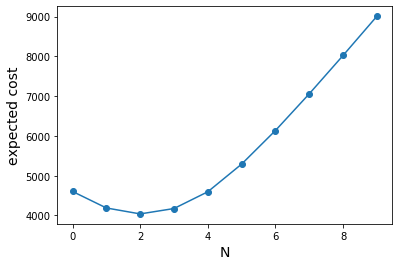

In [16]:
plt.plot(expected_costs, "o-")
plt.xlabel("N", fontsize=14)
plt.ylabel("expected cost", fontsize=14);

## Challenge: reuse your analysis to answer a harder question

Our original dataset contained the historical counts of elevator failures in your building, as well as buildings where three of your friends work. Could you save money if the four of you combined forces with a single shared service plan, or are you better off with four separate plans?

In [17]:
# DELETE CODE FOR THIS ENTIRE SECTION FOR LAB

In [18]:
min_cost = {"you":np.min(expected_costs)}

In [19]:
for f in ["friend1", "friend2", "friend3"]:
    fit = model.sampling(data={"y":failures[f], "N":len(failures)}, iter=10000, chains=4)
    posterior_samples = fit.extract()["lam"]
    expected_costs_f = []

    for i in range(10):
        expectation_value = np.mean([cost_function(np.random.poisson(lam),i) for lam in posterior_samples])
        expected_costs_f.append(expectation_value)
        
    min_cost[f] = np.min(expected_costs_f)

In [20]:
min_cost

{'you': 4038.725, 'friend1': 5098.5, 'friend2': 4023.65, 'friend3': 2974.675}

In [21]:
total_failures = failures.values.sum(axis=1)

In [22]:
total_failures

array([14,  8,  9, 14, 15])

In [23]:
fit = model.sampling(data={"y":total_failures, "N":len(failures)}, iter=10000, chains=4)
posterior_samples = fit.extract()["lam"]
expected_costs_s = []

for i in range(10):
    expectation_value = np.mean([cost_function(np.random.poisson(lam),i) for lam in posterior_samples])
    expected_costs_s.append(expectation_value)
    
shared_min_cost = np.min(expected_costs_s)

In [24]:
# EXPECTED COST FOR RISK POOLING

In [25]:
shared_min_cost

13207.2

In [26]:
# EXPECTED COST FOR INDEPENDENT SERVICE CONTRACTS

In [27]:
np.sum(list(min_cost.values()))

16135.55